In [4]:
# import tensorflow as tf
# from tensorflow import keras
# # import keras_cv
# from tensorflow.keras import layers
# # from keras_cv import utils
# # from keras_cv.layers import BaseImageAugmentationLayer
# import matplotlib.pyplot as plt

# import tensorflow as tf
# import tensorflow_addons as tfa
# import numpy as np
# from tensorflow import keras
# from tensorflow.keras import layers
# import pandas as pd
# from google.colab.patches import cv2
# import os

# Data preparation


(28, 28, 1)


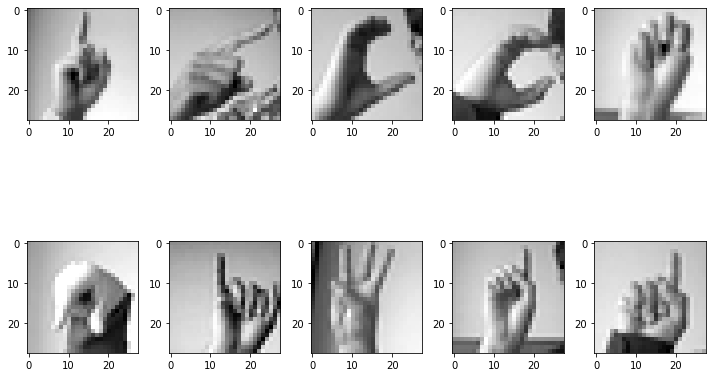

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
DATA_PATH_TRAIN = "/content/drive/MyDrive/classes/CS 4262/Project/MNIST Data/sign_mnist_train.csv"

train = pd.read_csv(DATA_PATH_TRAIN)
y_train = train['label']
X_train = train.drop(['label'], axis=1)

#normalize data
X_train = X_train.values/255
X_train = X_train.reshape(-1,28,28,1)

print(X_train[0].shape)

#visualize data
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(X_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()  

# Function Definition

In [3]:
import numpy as np
def randomWarp(image, factor=0.9):
  row = image.shape[0]
  col = image.shape[1]
  delta_range = min(row,col)/2
  
  # input points for homography
  p0 = [0,0]
  p1 = [0,col]
  p2 = [row,col]
  p3 = [row,0]

  P = np.array([p0, p1, p2, p3])

  # expected output points of homography
  p0_hat = [np.random.uniform(0,factor)*delta_range, np.random.uniform(0,factor)*delta_range]
  p1_hat = [np.random.uniform(0,factor)*delta_range, col-np.random.uniform(0,factor)*delta_range]
  p2_hat = [row-np.random.uniform(0,factor)*delta_range, col-np.random.uniform(0,factor)*delta_range]
  p3_hat = [row-np.random.uniform(0,factor)*delta_range, np.random.uniform(0,factor)*delta_range]

  P_hat = np.array([p0_hat, p1_hat, p2_hat, p3_hat])
  P_hat = P_hat.astype(int)

  A = []
  for i in range(4):
    A_i =np.array([-P[i][0], -P[i][1], -1, 0,    0,     0,  P[i][0]*P_hat[i][0], P[i][1]*P_hat[i][0], P_hat[i][0]]);
    A=np.append(A, A_i, axis=0)

    A_i = np.array([0,     0,     0, -P[i][0], -P[i][1], -1, P[i][0]*P_hat[i][1], P[i][1]*P_hat[i][1], P_hat[i][1]]);
    A=np.append(A, A_i, axis=0)

  A = np.reshape(A, (8,9))

  u, s, vh = np.linalg.svd(A, full_matrices=True)
  h = vh[-1]

  H = np.reshape(h,(3,3))
  return H

In [5]:
!pip install keras-cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394 kB 5.0 MB/s 


In [9]:
from keras_cv.layers import BaseImageAugmentationLayer
import tensorflow as tf
import cv2

class RandomImageWarp(BaseImageAugmentationLayer):
  def __init__(self, warp_factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.warp_factor = warp_factor

  def augment_image(self, images, transformation=None, **kwargs):
    [*others, src] = tf.unstack(images, axis=-1)
    H = randomWarp(src, factor=self.warp_factor)
    result = cv2.warpPerspective(src.numpy(), H, (28, 28))
    return tf.stack([*others, result], axis=-1)

# Effect Demonstration

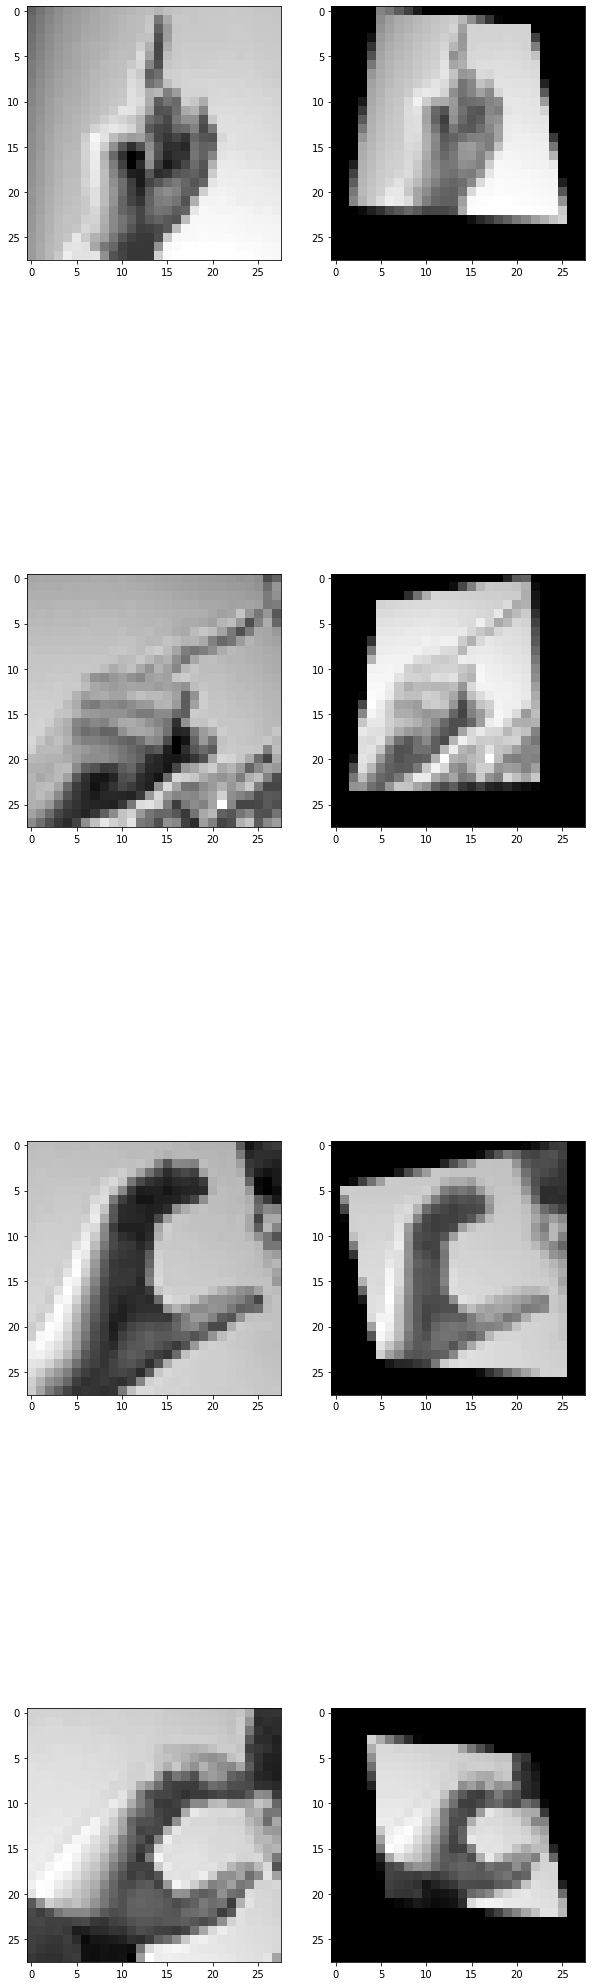

In [11]:
layer = RandomImageWarp(warp_factor=0.5)
f, ax = plt.subplots(4,2)
f.set_figwidth(10)
f.set_figheight(40)

for idx in range(0, 4):
    aug = layer(X_train[idx])
    # print(aug)
    ax[idx, 0].imshow(X_train[idx].reshape(28,28),cmap="gray");
    ax[idx, 1].imshow(aug.numpy().reshape(28,28),cmap="gray")